<a href="https://colab.research.google.com/github/Basantallam/unilm/blob/master/DiT_ObjectDetection_FineTuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installations**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 7.1 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.9 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install torch

# **Importing Sample Images from PubLayNet Dataset**

In [ ]:
# importing prerequisites
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
fname = 'examples.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)


6461141

In [ ]:
# Extracting the dataset
tar = tarfile.open(fname)
tar.extractall()
tar.close()

In [ ]:
# Verifying the file was extracted properly
data_path = "examples/"
path.exists(data_path)

True

# **Visualizing The PubLayNet Dataset**

In [ ]:
# Define color code
colors = {'title': (255, 0, 0),
          'text': (0, 255, 0),
          'figure': (0, 0, 255),
          'table': (255, 255, 0),
          'list': (0, 255, 255)}


In [ ]:
# Function to viz the annotation
def markup(image, annotations):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw segmentation
        draw.polygon(annotation['segmentation'][0],
                     fill=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (64,))
        # Draw bbox
        draw.rectangle(
            (annotation['bbox'][0],
             annotation['bbox'][1],
             annotation['bbox'][0] + annotation['bbox'][2],
             annotation['bbox'][1] + annotation['bbox'][3]),
            outline=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (255,),
            width=2
        )
        # Draw label
        w, h = draw.textsize(text=samples['categories'][annotation['category_id'] - 1]['name'],
                             font=font)
        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
    return np.array(image)

In [ ]:
# Parse the JSON file and read all the images and labels
with open('examples/samples.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)



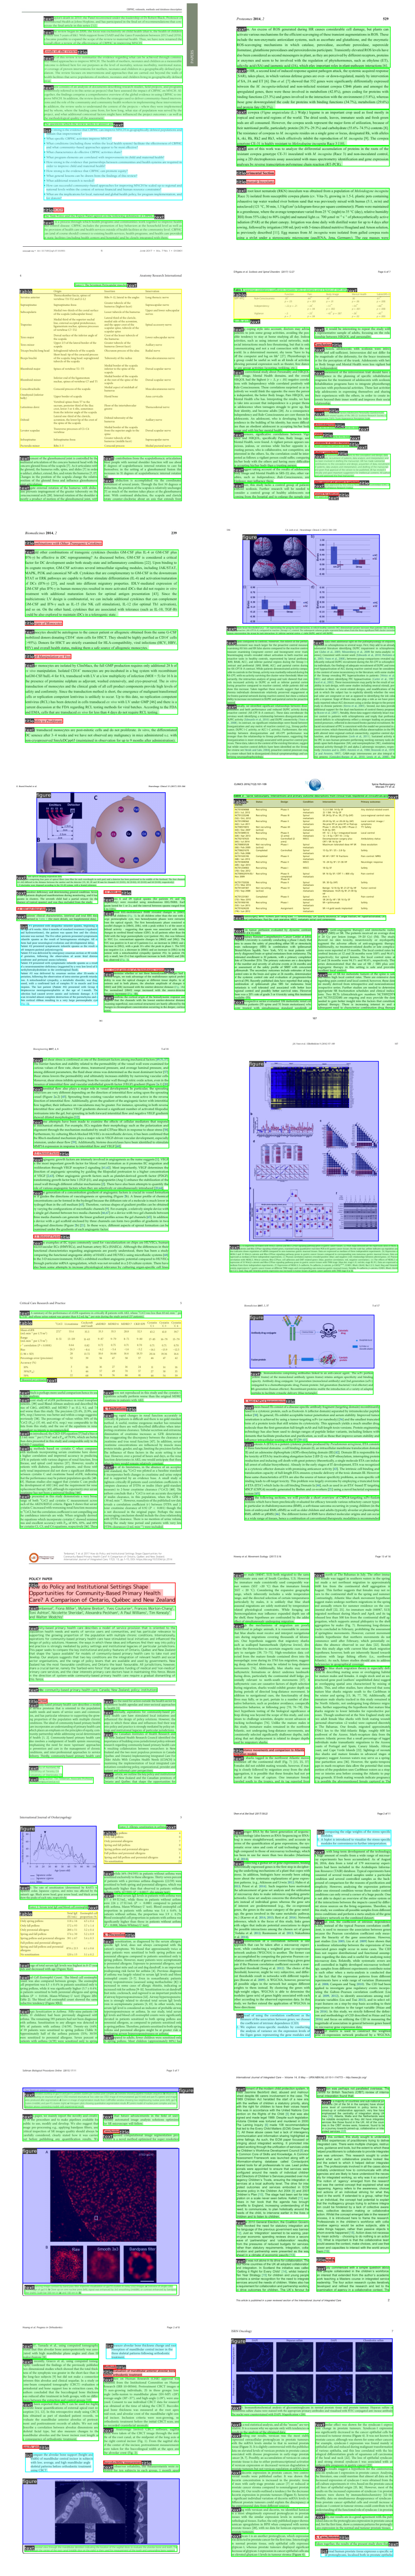

In [ ]:
# Visualize annotations
font = ImageFont.truetype("examples/DejaVuSans.ttf", 15)
fig=plt.figure(figsize=(16, 100)) 
for i, (_, image) in enumerate(images.items()):
    with Image.open(image['file_name']) as img:
        ax = plt.subplot(len(images) / 2, 2, i + 1)
        ax.imshow(markup(img, image['annotations']))
        ax.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

# **Cloning Repo**

In [ ]:
!git clone https://github.com/microsoft/unilm

Cloning into 'unilm'...
remote: Enumerating objects: 5853, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 5853 (delta 15), reused 34 (delta 10), pack-reused 5806
Receiving objects: 100% (5853/5853), 9.97 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (2460/2460), done.


# **Installing Detectron2**

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ty8z5qo7
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ty8z5qo7


In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 8.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=1c02f2472f42c64d995e7e26d9390ecb1fbb3cb57e5feab834b2da2cf2392575
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
torch:  1.11 ; cuda:  cu113
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.11/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 10.5 MB/s 


# **Testing Object Detection with Image**


### **Model Input**

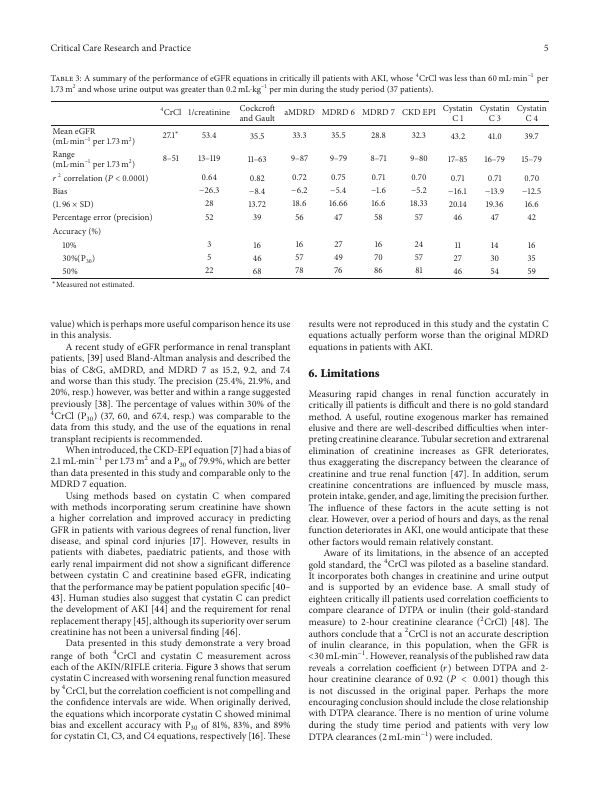

In [ ]:
!python /content/unilm/dit/object_detection/inference.py \
--image_path /content/drive/MyDrive/Bachelor/Datasets/publaynet_example.jpeg \
--output_file_name output.jpg \
--config /content/drive/MyDrive/Bachelor/DiT_Models/maskrcnn_dit_base.yaml \
--opts MODEL.WEIGHTS https://layoutlm.blob.core.windows.net/dit/dit-fts/publaynet_dit-b_mrcnn.pth \

publaynet_dit-b_mrcnn.pth: 453MB [00:04, 92.8MB/s]              
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### **Model Output**

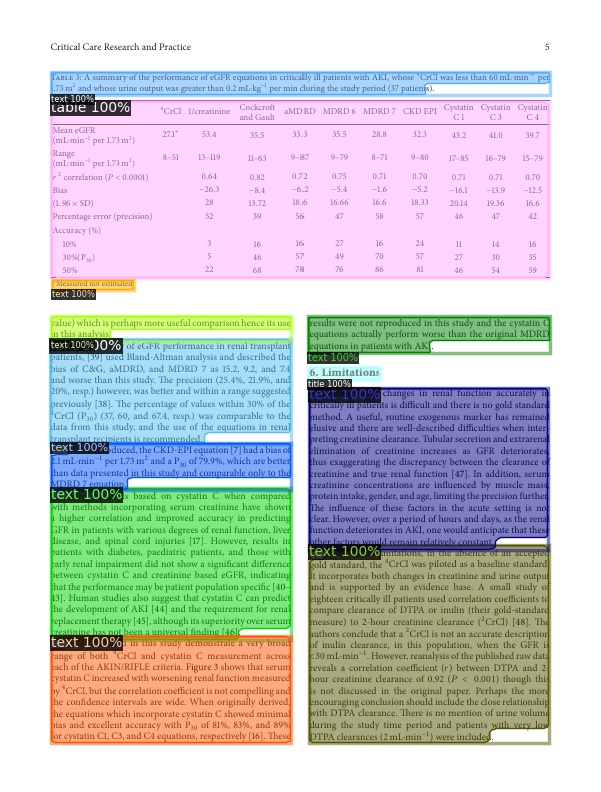

# **Evaluation**

Evaluation Gives Error because needs more GPUs

In [ ]:
!python /content/unilm/dit/object_detection/train_net.py --config-file /content/unilm/dit/object_detection/publaynet_configs/maskrcnn/maskrcnn_dit_base.yaml --eval-only --num-gpus 8 MODEL.WEIGHTS /content/drive/MyDrive/Bachelor/DiT_Models/publaynet_dit-b_mrcnn.pth OUTPUT_DIR /content/output.jpg

Command Line Args: Namespace(config_file='/content/unilm/dit/object_detection/publaynet_configs/maskrcnn/maskrcnn_dit_base.yaml', debug=False, dist_url='tcp://127.0.0.1:49152', eval_only=True, machine_rank=0, num_gpus=8, num_machines=1, opts=['MODEL.WEIGHTS', '/content/drive/MyDrive/Bachelor/DiT_Models/publaynet_dit-b_mrcnn.pth', 'OUTPUT_DIR', '/content/output.jpg'], resume=False)
Traceback (most recent call last):
  File "/content/unilm/dit/object_detection/train_net.py", line 122, in <module>
    args=(args,),
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/launch.py", line 79, in launch
    daemon=False,
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/spawn.py", line 240, in spawn
    return start_processes(fn, args, nprocs, join, daemon, start_method='spawn')
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/spawn.py", line 198, in start_processes
    while not context.join():
  File "/usr/local/lib/python3.7/dist-packages/to